In [1]:
import xarray as xr
from glob import glob
from datetime import datetime
import yaml
import sys
sys.path.append('../../')

import plotting

from conf.global_settings import OUTPUT_DIR
from utils.file_utils import get_date
from transformations.transformation import Transformation

In [2]:
ds_name = "SSMIS_OSI-430-a_daily"
hemisphere = 'nh'
with open(f'conf/ds_configs/{ds_name}.yaml', 'r') as stream:
    config = yaml.load(stream, yaml.Loader)

# Load sample granule

In [3]:
ds_granules_dir = f'{OUTPUT_DIR}/{ds_name}/harvested_granules/'
ds_granules = glob(f'{ds_granules_dir}/**/*.nc*')
if hemisphere:
    ds_granules = [g for g in ds_granules if hemisphere in g]
sample_granule_path = ds_granules[0]
print(sample_granule_path)

/Users/marlis/Developer/ECCO/ecco_output/SSMIS_OSI-430-a_daily/harvested_granules/2022/ice_conc_nh_ease2-250_icdr-v3p0_202206041200.nc


In [4]:
filename_date_str = get_date(config['filename_date_regex'], sample_granule_path.split('/')[-1])
granule_date = datetime.strptime(filename_date_str, config['filename_date_fmt']).strftime('%Y-%m-%dT%H:%M:%SZ')
ds = xr.open_dataset(sample_granule_path)
ds

<xarray.Dataset>
Dimensions:                         (time: 1, nv: 2, xc: 432, yc: 432)
Coordinates:
  * time                            (time) datetime64[ns] 2022-06-04T12:00:00
  * xc                              (xc) float64 -5.388e+03 ... 5.388e+03
  * yc                              (yc) float64 5.388e+03 ... -5.388e+03
    lat                             (yc, xc) float32 ...
    lon                             (yc, xc) float32 ...
Dimensions without coordinates: nv
Data variables:
    Lambert_Azimuthal_Grid          int32 ...
    time_bnds                       (time, nv) datetime64[ns] ...
    ice_conc                        (time, yc, xc) float64 ...
    raw_ice_conc_values             (time, yc, xc) float64 ...
    total_standard_uncertainty      (time, yc, xc) float64 ...
    smearing_standard_uncertainty   (time, yc, xc) float64 ...
    algorithm_standard_uncertainty  (time, yc, xc) float64 ...
    status_flag                     (time, yc, xc) float32 ...
Attributes: (12/43)
    topiccategory:             Oceans ClimatologyMeteorologyAtmosphere
    keywords:                  GCMDSK:Earth Science > Cryosphere > Sea Ice > ...
    keywords_vocabulary:       GCMDSK:GCMD Science Keywords:https://gcmd.eart...
    geospatial_lat_min:        16.62393
    geospatial_lat_max:        90.0
    geospatial_lon_min:        -180.0
    ...                        ...
    creator_url:               https://osi-saf.eumetsat.int/
    references:                Product User Manual v3 (2022),Algorithm Theore...
    contributor_name:          Thomas Lavergne,Atle Soerensen,Rasmus Tonboe,C...
    contributor_role:          PrincipalInvestigator,author,author,author,aut...
    standard_name_vocabulary:  CF Standard Name Table (Version 78, 21 Septemb...
    naming_authority:          int.eumetsat

# Load grid

In [5]:
grids = glob(f'grids/*.nc*')
grids.sort()
f'Available grids: {grids}'

"Available grids: ['grids/ECCO_llc270.nc', 'grids/ECCO_llc90.nc', 'grids/grid_tpose6_radius.nc', 'grids/polar_stereo_n_25km.nc']"

In [6]:
grid_ds = xr.open_dataset(grids[1])
grid_ds

<xarray.Dataset>
Dimensions:                (tile: 13, j: 90, i: 90)
Coordinates:
  * tile                   (tile) int16 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j                      (j) int16 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * i                      (i) int16 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
Data variables:
    XC                     (tile, j, i) float32 ...
    YC                     (tile, j, i) float32 ...
    effective_grid_radius  (tile, j, i) float32 ...
Attributes:
    name:                  ECCO_llc90
    type:                  llc
    geospatial_lat_min:    -89.873055
    geospatial_lat_max:    89.739395
    geospatial_lon_min:    -179.98895
    geospatial_lon_max:    179.98691
    geospatial_lat_units:  degrees_north
    geospatial_lon_units:  degrees_east

In [7]:
T = Transformation(config, sample_granule_path, granule_date)

# Make mapping factors

In [8]:
factors = T.make_factors(grid_ds)

# Transformation

In [9]:
field_ds_list = T.transform(grid_ds, factors, ds, config)

Processing field ice_conc
Processing field total_standard_uncertainty


In [10]:
field_ds = field_ds_list[0][0]
field_ds

<xarray.Dataset>
Dimensions:                              (time: 1, tile: 13, j: 90, i: 90, nv: 2)
Coordinates:
  * time                                 (time) datetime64[ns] 2022-06-03T12:...
  * tile                                 (tile) int16 0 1 2 3 4 ... 8 9 10 11 12
  * j                                    (j) int16 0 1 2 3 4 ... 85 86 87 88 89
  * i                                    (i) int16 0 1 2 3 4 ... 85 86 87 88 89
    XC                                   (tile, j, i) float32 -111.6 ... -111.9
    YC                                   (tile, j, i) float32 -88.24 ... -88.1
    time_bnds                            (time, nv) datetime64[ns] 2022-06-03...
Dimensions without coordinates: nv
Data variables:
    ice_conc_interpolated_to_ECCO_llc90  (time, tile, j, i) float64 9.969e+36...
Attributes:
    interpolated_grid:            ECCO_llc90
    model_grid_type:              llc
    original_dataset_title:       Global Sea Ice Concentration interim climat...
    original_dataset_short_name:  Global Sea Ice Concentration interim climat...
    original_dataset_url:         https://osi-saf.eumetsat.int/products/osi-4...
    original_dataset_reference:   https://osisaf-hl.met.no/sites/osisaf-hl.me...
    original_dataset_doi:         10.15770/EUM_SAF_OSI_0014
    interpolated_grid_id:         ECCO_llc90
    transformation_version:       1.7
    notes:

# Visualization

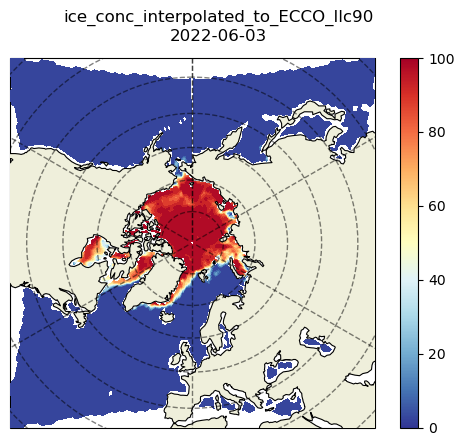

In [12]:
plotting.make_plot(field_ds[list(field_ds_list[0][0].data_vars)[0]], 'nh')


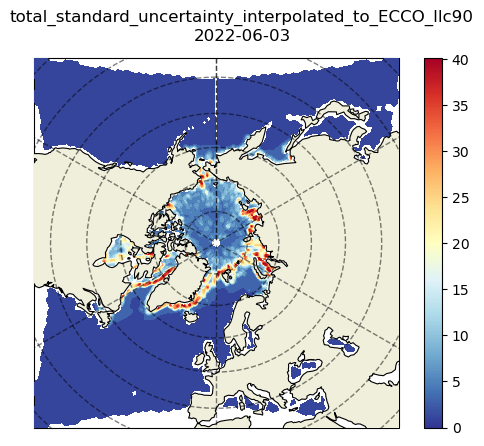

In [23]:
plotting.make_plot(field_ds_list[1][0][list(field_ds_list[1][0].data_vars)[0]], 'nh')